### Time-series forecasting with deep learning & LSTM autoencoders & Transformers
The purpose of this work is to show one way time-series data can be effiently encoded to lower dimensions, to be used into non time-series models.

Here I'll encode a time-series of size 12 (12 months) to a single value and use it on a MLP deep learning model, instead of using the time-series on a LSTM model that could be the regular approach.and try Transformers on time series data.

The first part of the data preparation is from my other kernel Model stacking, feature engineering and EDA.

This work was inspired by this Machinelearningmastery post A Gentle Introduction to LSTM Autoencoders.

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

Data fields description:

ID - an Id that represents a (Shop, Item) tuple within the test set

shop_id - unique identifier of a shop

item_id - unique identifier of a product

item_category_id - unique identifier of item category

date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

date - date in format dd/mm/yyyy

item_cnt_day - number of products sold. You are predicting a monthly amount of this measure

item_price - current price of an item

item_name - name of item

shop_name - name of shop

item_category_name - name of item category

#### Dependencies

In [10]:
import os, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras import optimizers, Sequential, Model

# Set seeds to make the experiment more reproducible.
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

loading data

In [11]:
test = pd.read_csv("C:/projects/forcasting time series proejct/competitive-data-science-predict-future-sales/test.csv", dtype={'ID': 'int32', 'shop_id': 'int32', 
                                                  'item_id': 'int32'})
item_categories = pd.read_csv("C:/projects/forcasting time series proejct/competitive-data-science-predict-future-sales/item_categories.csv", 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
items = pd.read_csv("C:/projects/forcasting time series proejct/competitive-data-science-predict-future-sales/items.csv", dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})
shops = pd.read_csv("C:/projects/forcasting time series proejct/competitive-data-science-predict-future-sales/shops.csv", dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales = pd.read_csv("C:/projects/forcasting time series proejct/competitive-data-science-predict-future-sales/sales_train.csv", parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                      'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

Join data sets

In [12]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

Let's take a look at the raw data

In [13]:
print(f'Train rows: {train.shape[0]}')
print(f'Train columns: {train.shape[1]}')

display(train.head().T)
display(train.describe())

Train rows: 2935849
Train columns: 10


,0,1,2,3,4
date,02.01.2013,03.01.2013,05.01.2013,06.01.2013,15.01.2013
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999.00,899.00,899.00,1709.05,1099.00
item_cnt_day,1,1,-1,1,1
item_name,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE Who Do You Think We Are LP,DEEP PURPLE 30 Very Best Of 2CD (Фирм.)
item_category_id,37,58,58,58,56
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
item_category_name,Кино - Blu-Ray,Музыка - Винил,Музыка - Винил,Музыка - Винил,Музыка - CD фирменного производства


,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.85,1.24,40.00
std,9.42,16.23,6324.30,1726.44,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


Time period of the dataset

In [15]:
train['date'] = pd.to_datetime(train['date'], format='%d.%m.%Y')

# Safely access min and max dates
print(f"Min date from train set: {train['date'].min().date()}")
print(f"Max date from train set: {train['date'].max().date()}")

Min date from train set: 2013-01-01
Max date from train set: 2015-10-31


I'm leaving only the "shop_id" and "item_id" that exist in the test set to have more accurate results.

In [16]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
# Only shops that exist in test set.
train = train[train['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
train = train[train['item_id'].isin(test_item_ids)]

### Data preprocessing
I'm dropping all features but "item_cnt_day" because I'll be using only it as a univariate time-series.
We are asked to predict total sales for every product and store in the next month, and our data is given by day, so let's aggregate the data by month.
Also I'm leaving only monthly "item_cnt" >= 0 and <= 20, as this seems to be the distributions of the test set.

In [17]:
train_monthly = train[['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_cnt_day':['sum']})
train_monthly.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt']
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20')
# Label
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

display(train_monthly.head(10).T)
display(train_monthly.describe().T)

,0,1,2,3,4,5,6,7,8,9
date_block_num,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
shop_id,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00
item_id,33.00,482.00,491.00,839.00,1007.00,1010.00,1023.00,1204.00,1224.00,1247.00
item_cnt,1.00,1.00,1.00,1.00,3.00,1.00,2.00,1.00,1.00,1.00
item_cnt_month,2.00,1.00,1.00,1.00,1.00,1.00,1.00,NaN,NaN,NaN


,count,mean,std,min,25%,50%,75%,max
date_block_num,593829.00,20.18,9.14,0.00,13.00,22.00,28.00,33.00
shop_id,593829.00,32.07,16.90,2.00,19.00,31.00,47.00,59.00
item_id,593829.00,10015.02,6181.82,30.00,4418.00,9171.00,15334.00,22167.00
item_cnt,593829.00,2.10,2.31,0.00,1.00,1.00,2.00,20.00
item_cnt_month,482536.00,2.07,2.17,0.00,1.00,1.00,2.00,20.00


### Time-series processing
As I only need the "item_cnt" feature as a series, I can get that easily by just using a pivot operation.
This way I'll also get the missing months from each "shop_id" and "item_id", and then replace them with 0 (otherwise would be "nan").

In [18]:
monthly_series = train_monthly.pivot_table(index=['shop_id', 'item_id'], columns='date_block_num',values='item_cnt', fill_value=0).reset_index()
monthly_series.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,2,30,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2,31,0.00,4.00,1.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
2,2,32,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
3,2,33,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00,1.00,0.00
4,2,53,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Currently I have one series (33 months) for each unique pair of "shop_id" and "item_id", but probably would be better to have multiple smaller series for each unique pair, so I'm generating multiple series of size 12 (one year) for each unique pair.¶

In [19]:
first_month = 20
last_month = 33
serie_size = 12
data_series = []

for index, row in monthly_series.iterrows():
    for month1 in range((last_month - (first_month + serie_size)) + 1):
        serie = [row['shop_id'], row['item_id']]
        for month2 in range(serie_size + 1):
            serie.append(row[month1 + first_month + month2])
        data_series.append(serie)

columns = ['shop_id', 'item_id']
[columns.append(i) for i in range(serie_size)]
columns.append('label')

data_series = pd.DataFrame(data_series, columns=columns)
data_series.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,label
0,2.00,30.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2.00,30.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2.00,31.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,2.00,31.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
4,2.00,32.00,2.00,2.00,0.00,2.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00


Dropping identifier columns as we don't need them anymore.

In [20]:
data_series = data_series.drop(['item_id', 'shop_id'], axis=1)

Train and validation sets.

In [21]:
labels = data_series['label']
data_series.drop('label', axis=1, inplace=True)
train, valid, Y_train, Y_valid = train_test_split(data_series, labels.values, test_size=0.10, random_state=0)

In [22]:
print("Train set", train.shape)
print("Validation set", valid.shape)
train.head()

Train set (200327, 12)
Validation set (22259, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
207604,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
45150,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
143433,0.00,0.00,4.00,2.00,1.00,2.00,2.00,1.00,0.00,0.00,0.00,1.00
202144,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
136088,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00


#####  Reshape data.
Time-series shape (data points, time-steps, features).

In [23]:
X_train = train.values.reshape((train.shape[0], train.shape[1], 1))
X_valid = valid.values.reshape((valid.shape[0], valid.shape[1], 1))

print("Train set reshaped", X_train.shape)
print("Validation set reshaped", X_valid.shape)

Train set reshaped (200327, 12, 1)
Validation set reshaped (22259, 12, 1)


First let's begin with how a regular RNN time-series approach could be

### Regular LSTM model

In [24]:
serie_size =  X_train.shape[1] # 12
n_features =  X_train.shape[2] # 1

epochs = 20
batch = 128
lr = 0.0001

lstm_model = Sequential()
lstm_model.add(L.LSTM(10, input_shape=(serie_size, n_features), return_sequences=True))
lstm_model.add(L.LSTM(6, activation='relu', return_sequences=True))
lstm_model.add(L.LSTM(1, activation='relu'))
lstm_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(L.Dense(1))
lstm_model.summary()

adam = optimizers.Adam(lr)
lstm_model.compile(loss='mse', optimizer=adam)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 12, 10)              │             480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 12, 6)               │             408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 1)                   │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,061 (4.14 KB)

 Trainable params: 1,061 (4.14 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
lstm_history = lstm_model.fit(X_train, Y_train, 
                              validation_data=(X_valid, Y_valid), 
                              batch_size=batch, 
                              epochs=epochs, 
                              verbose=2)

Epoch 1/20
1566/1566 - 18s - 11ms/step - loss: 1.5252 - val_loss: 1.3319
Epoch 2/20
1566/1566 - 11s - 7ms/step - loss: 1.3238 - val_loss: 1.2429
Epoch 3/20
1566/1566 - 11s - 7ms/step - loss: 1.2452 - val_loss: 1.2015
Epoch 4/20
1566/1566 - 11s - 7ms/step - loss: 1.2102 - val_loss: 1.1821
Epoch 5/20
1566/1566 - 13s - 8ms/step - loss: 1.1940 - val_loss: 1.1716
Epoch 6/20
1566/1566 - 14s - 9ms/step - loss: 1.1856 - val_loss: 1.1651
Epoch 7/20
1566/1566 - 17s - 11ms/step - loss: 1.1804 - val_loss: 1.1604
Epoch 8/20
1566/1566 - 17s - 11ms/step - loss: 1.1768 - val_loss: 1.1568
Epoch 9/20
1566/1566 - 13s - 8ms/step - loss: 1.1740 - val_loss: 1.1539
Epoch 10/20
1566/1566 - 13s - 8ms/step - loss: 1.1717 - val_loss: 1.1516
Epoch 11/20
1566/1566 - 12s - 8ms/step - loss: 1.1698 - val_loss: 1.1497
Epoch 12/20
1566/1566 - 13s - 9ms/step - loss: 1.1682 - val_loss: 1.1481
Epoch 13/20
1566/1566 - 13s - 9ms/step - loss: 1.1668 - val_loss: 1.1468
Epoch 14/20
1566/1566 - 12s - 8ms/step - loss: 1.1656 - v

### Autoencoder

Now we will build an autoencoder to learn how to reconstruct the input, this way it internally learns the best way to represent the input in lower dimensions.

The reconstruct model is composed of an encoder and a decoder, the encoder is responsible for learning how to represent the input into lower dimensions and the decoder learns how to rebuild the smaller representations into the input again.

Here is a structural representations of an autoencoder:
After the models is trained we can keep only the encoder part and we'll have a model that is able to do what we want.
#### LSTM Autoencoder.

In [26]:
encoder_decoder = Sequential()
encoder_decoder.add(L.LSTM(serie_size, activation='relu', input_shape=(serie_size, n_features), return_sequences=True))
encoder_decoder.add(L.LSTM(6, activation='relu', return_sequences=True))
encoder_decoder.add(L.LSTM(1, activation='relu'))
encoder_decoder.add(L.RepeatVector(serie_size))
encoder_decoder.add(L.LSTM(serie_size, activation='relu', return_sequences=True))
encoder_decoder.add(L.LSTM(6, activation='relu', return_sequences=True))
encoder_decoder.add(L.TimeDistributed(L.Dense(1)))
encoder_decoder.summary()

adam = optimizers.Adam(lr)
encoder_decoder.compile(loss='mse', optimizer=adam)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 12, 12)              │             672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 12, 6)               │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 1)                   │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 12, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 12, 12)              │             672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 12, 6)               │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 12, 1)               │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,295 (8.96 KB)

 Trainable params: 2,295 (8.96 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
encoder_decoder_history = encoder_decoder.fit(X_train, X_train, 
                                              batch_size=batch, 
                                              epochs=epochs, 
                                              verbose=2)

Epoch 1/20
1566/1566 - 27s - 17ms/step - loss: 1.7744
Epoch 2/20
1566/1566 - 21s - 13ms/step - loss: 1.6861
Epoch 3/20
1566/1566 - 21s - 13ms/step - loss: 1.3032
Epoch 4/20
1566/1566 - 23s - 15ms/step - loss: 1.1481
Epoch 5/20
1566/1566 - 22s - 14ms/step - loss: 1.0927
Epoch 6/20
1566/1566 - 21s - 13ms/step - loss: 1.0633
Epoch 7/20
1566/1566 - 22s - 14ms/step - loss: 1.0477
Epoch 8/20
1566/1566 - 22s - 14ms/step - loss: 1.0321
Epoch 9/20
1566/1566 - 21s - 14ms/step - loss: 1.0126
Epoch 10/20
1566/1566 - 26s - 17ms/step - loss: 0.9985
Epoch 11/20
1566/1566 - 22s - 14ms/step - loss: 0.9875
Epoch 12/20
1566/1566 - 22s - 14ms/step - loss: 0.9797
Epoch 13/20
1566/1566 - 21s - 14ms/step - loss: 0.9714
Epoch 14/20
1566/1566 - 22s - 14ms/step - loss: 0.9654
Epoch 15/20
1566/1566 - 21s - 14ms/step - loss: 0.9567
Epoch 16/20
1566/1566 - 21s - 13ms/step - loss: 0.9528
Epoch 17/20
1566/1566 - 21s - 14ms/step - loss: 0.9479
Epoch 18/20
1566/1566 - 21s - 13ms/step - loss: 0.9472
Epoch 19/20
1566/15

You should be aware that the better the autoencoder is able to reconstruct the input the better it internally encodes the input, in other words if we have a good autoencoder we probably will have an equally good encoder.

Let's take a look at the layers of the encoder_decoder model:

In [28]:
rpt_vector_layer = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[3].output)
time_dist_layer = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[5].output)
encoder_decoder.layers

[<LSTM name=lstm_3, built=True>,
 <LSTM name=lstm_4, built=True>,
 <LSTM name=lstm_5, built=True>,
 <RepeatVector name=repeat_vector, built=True>,
 <LSTM name=lstm_6, built=True>,
 <LSTM name=lstm_7, built=True>,
 <TimeDistributed name=time_distributed, built=True>]

About the autoencoder layers

LSTM

This is just a regular LSTM layer, a layer that is able to receive sequence data and learn based on it nothing much to talk about.

RepeatVector layer

Here is something we don't usually see, this layers basically repeats it's input "n" times, the reason to use it is because the last layers from the encoder part (the layer with one neuron) don't return sequences, so it does not outputs a sequenced data, this way we can't just add another LSTM layer after it, we need a way to turn this output into a sequence of the same time-steps of the model input, this is where "RepeatVector" layers comes in.

Let's see what it outputs.

In [29]:
rpt_vector_layer_output = rpt_vector_layer.predict(X_train[:1])
print('Repeat vector output shape', rpt_vector_layer_output.shape)
print('Repeat vector output sample')
print(rpt_vector_layer_output[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
Repeat vector output shape (1, 12, 1)
Repeat vector output sample
[[1.8766562e-08]
 [1.8766562e-08]
 [1.8766562e-08]
 [1.8766562e-08]
 [1.8766562e-08]
 [1.8766562e-08]
 [1.8766562e-08]
 [1.8766562e-08]
 [1.8766562e-08]
 [1.8766562e-08]
 [1.8766562e-08]
 [1.8766562e-08]]


As you can see this is just the same value repeated some times to match the same shape of the model input.

TimeDistributed layer

This layer is more common, sometimes is used when you want to mix RNN layers with other kind of layers.
We could output the model with another LSTM layer with one neuron and "return_sequences=True" parameter, but using a "TimeDistributed" layer wrapping a "Dense" layer we will have the same weights for each outputted time-step.

In [30]:
time_dist_layer_output = time_dist_layer.predict(X_train[:1])
print('Time distributed output shape', time_dist_layer_output.shape)
print('Time distributed output sample')
print(time_dist_layer_output[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
Time distributed output shape (1, 12, 6)
Time distributed output sample
[[0.06758494 0.09808452 0.03582265 0.01930904 0.06091176 0.        ]
 [0.14439945 0.14422725 0.03998621 0.06076688 0.14426228 0.        ]
 [0.21463703 0.15035163 0.0300399  0.11093035 0.2297557  0.        ]
 [0.26960716 0.12839639 0.02257828 0.15955795 0.3032656  0.        ]
 [0.3089735  0.09811125 0.01704414 0.19956341 0.35969773 0.        ]
 [0.33539677 0.07515506 0.01298897 0.23161498 0.40069684 0.        ]
 [0.35362247 0.0576563  0.00995542 0.25834414 0.4271436  0.        ]
 [0.36679143 0.04427055 0.00765318 0.2807247  0.43937957 0.        ]
 [0.37674433 0.03400611 0.00589155 0.2987465  0.43889496 0.        ]
 [0.3844781  0.02684826 0.00453728 0.31206802 0.42822748 0.        ]
 [0.39059266 0.02987105 0.00349371 0.32061902 0.4105044  0.        ]
 [0.39637154 0.03988958 0.00268969 0.32606047 0.38962415 0.        ]]


Defining the encoding model.

What I want is to encode the whole series into a single value, so I need the output from the layer with a single neuron (in this case it's the third LSTM layer).

I'll take only the encoding part of the model and define it as a new one

In [31]:
encoder = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[2].output)

Now let's encode the train and validation time-series.

In [32]:
train_encoded = encoder.predict(X_train)
validation_encoded = encoder.predict(X_valid)
print('Encoded time-series shape', train_encoded.shape)
print('Encoded time-series sample', train_encoded[0])

6261/6261 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
696/696 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Encoded time-series shape (200327, 1)
Encoded time-series sample [1.876665e-08]


Add new encoded features to the train and validation sets.

In [33]:
train['encoded'] = train_encoded
train['label'] = Y_train

valid['encoded'] = validation_encoded
valid['label'] = Y_valid

train.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,encoded,label
207604,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
45150,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
143433,0.00,0.00,4.00,2.00,1.00,2.00,2.00,1.00,0.00,0.00,0.00,1.00,0.30,1.00
202144,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
136088,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.16,1.00
121675,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00
185281,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
70087,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,1.00,3.00,0.60,0.00
105249,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
183257,0.00,0.00,0.00,0.00,0.00,3.00,0.00,1.00,0.00,0.00,0.00,1.00,0.38,0.00


Now we can use the new encoded feature that is a representation of the whole time-series and train a "less complex" model that does not receives sequenced data as input

###  MLP with LSTM encoded feature

For the MLP model I'm only using the current month "item_count" and the encoded time-series feature from our LSTM encoder model, the idea is that we won't need the whole series because we already have a column that represents the whole series into a single value (it's like a dimensionality reduction).

In [35]:
last_month = serie_size - 1
Y_train_encoded = train['label']
train.drop('label', axis=1, inplace=True)
X_train_encoded = train[[last_month, 'encoded']]

Y_valid_encoded = valid['label']
valid.drop('label', axis=1, inplace=True)
X_valid_encoded = valid[[last_month, 'encoded']]

print("Train set", X_train_encoded.shape)
print("Validation set", X_valid_encoded.shape)

Train set (200327, 2)
Validation set (22259, 2)


In [36]:
X_train_encoded.head()

,11,encoded
207604,0.00,0.00
45150,0.00,0.00
143433,1.00,0.30
202144,0.00,0.00
136088,0.00,0.16


In [37]:
mlp_model = Sequential()
mlp_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu', input_dim=X_train_encoded.shape[1]))
mlp_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
mlp_model.add(L.Dense(1))
mlp_model.summary()

adam = optimizers.Adam(lr)
mlp_model.compile(loss='mse', optimizer=adam)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 151 (604.00 B)

 Trainable params: 151 (604.00 B)

 Non-trainable params: 0 (0.00 B)

In [38]:
mlp_history = mlp_model.fit(X_train_encoded.values, Y_train_encoded.values, epochs=epochs, batch_size=batch, validation_data=(X_valid_encoded, Y_valid_encoded), verbose=2)


Epoch 1/20
1566/1566 - 4s - 2ms/step - loss: 1.2804 - val_loss: 1.2087
Epoch 2/20
1566/1566 - 2s - 1ms/step - loss: 1.2416 - val_loss: 1.2049
Epoch 3/20
1566/1566 - 3s - 2ms/step - loss: 1.2398 - val_loss: 1.2040
Epoch 4/20
1566/1566 - 2s - 1ms/step - loss: 1.2390 - val_loss: 1.2033
Epoch 5/20
1566/1566 - 2s - 1ms/step - loss: 1.2378 - val_loss: 1.2013
Epoch 6/20
1566/1566 - 3s - 2ms/step - loss: 1.2353 - val_loss: 1.1989
Epoch 7/20
1566/1566 - 2s - 2ms/step - loss: 1.2332 - val_loss: 1.1976
Epoch 8/20
1566/1566 - 2s - 1ms/step - loss: 1.2316 - val_loss: 1.1962
Epoch 9/20
1566/1566 - 2s - 1ms/step - loss: 1.2301 - val_loss: 1.1945
Epoch 10/20
1566/1566 - 2s - 1ms/step - loss: 1.2284 - val_loss: 1.1926
Epoch 11/20
1566/1566 - 2s - 1ms/step - loss: 1.2264 - val_loss: 1.1906
Epoch 12/20
1566/1566 - 2s - 1ms/step - loss: 1.2248 - val_loss: 1.1889
Epoch 13/20
1566/1566 - 2s - 1ms/step - loss: 1.2236 - val_loss: 1.1879
Epoch 14/20
1566/1566 - 2s - 1ms/step - loss: 1.2229 - val_loss: 1.1872
E

## Comparing models
As you can see I tried to build both models with a similar topology (type/number of layers and neurons), so it could make more sense to compare them.

The results are pretty close, also they may change a bit depending on the random initialization of the networks weights, so I would say they are very similar in terms of performance.

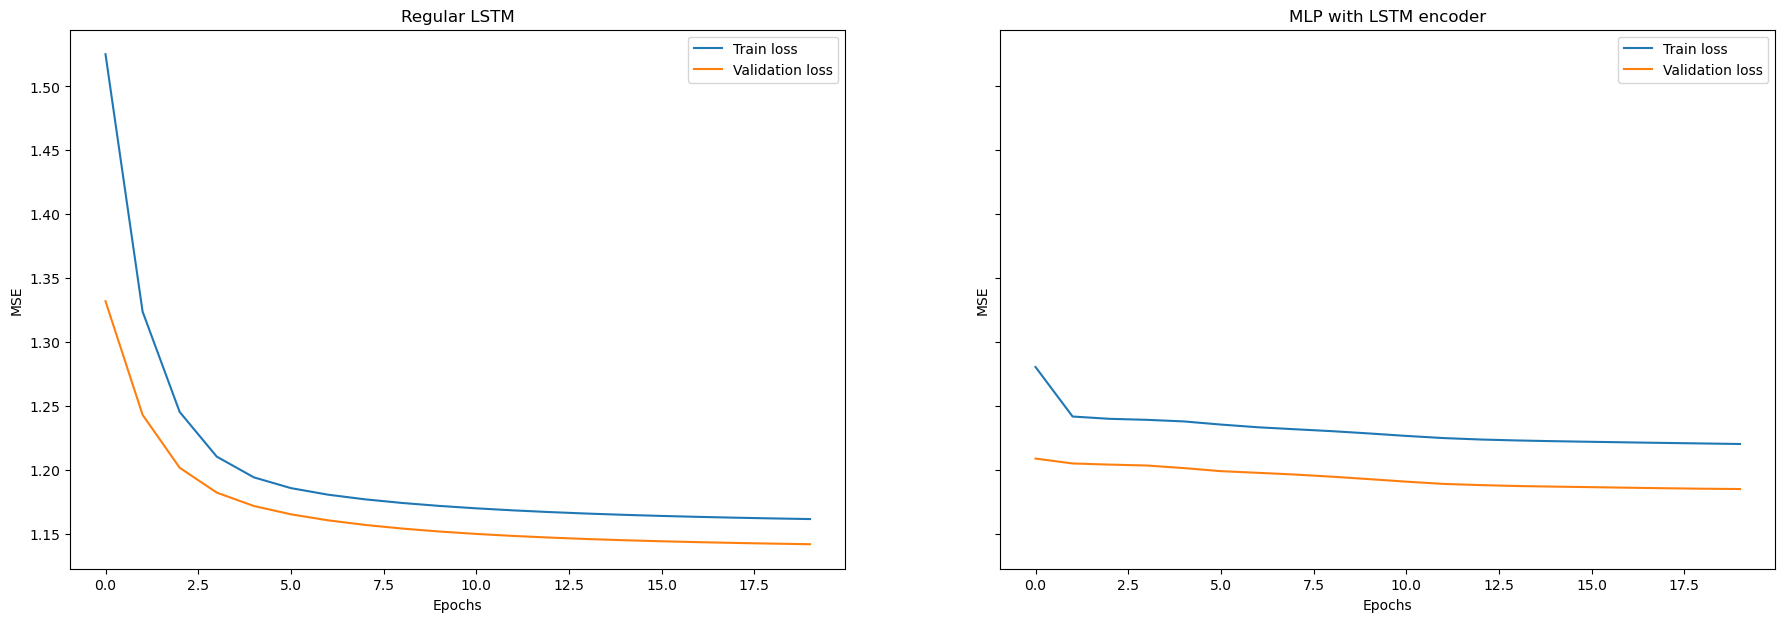

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(22,7))

ax1.plot(lstm_history.history['loss'], label='Train loss')
ax1.plot(lstm_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Regular LSTM')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(mlp_history.history['loss'], label='Train loss')
ax2.plot(mlp_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('MLP with LSTM encoder')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

plt.show()

Regular LSTM on train and validation.

In [40]:
lstm_train_pred = lstm_model.predict(X_train)
lstm_val_pred = lstm_model.predict(X_valid)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_val_pred)))

6261/6261 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
696/696 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Train rmse: 1.0767401068282796
Validation rmse: 1.068486556095158


MLP with LSTM encoder on train and validation.

In [41]:
mlp_train_pred2 = mlp_model.predict(X_train_encoded.values)
mlp_val_pred2 = mlp_model.predict(X_valid_encoded.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_encoded, mlp_train_pred2)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_encoded, mlp_val_pred2)))

6261/6261 ━━━━━━━━━━━━━━━━━━━━ 5s 751us/step
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
Train rmse: 1.104215245352557
Validation rmse: 1.0885125901861317


Build test set
Since we have two models I'll build test sets to apply on both of them

In [42]:
latest_records = monthly_series.drop_duplicates(subset=['shop_id', 'item_id'])
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test.fillna(0, inplace=True)
X_test.drop(['ID', 'item_id', 'shop_id'], axis=1, inplace=True)
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,2.00,0.00,0.00,0.00,1.00,1.00,1.00,3.00,1.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,3.00,2.00,0.00,1.00,3.00,1.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [43]:
X_test = X_test[[(i + (34 - serie_size)) for i in range(serie_size)]]
X_test.head()

,22,23,24,25,26,27,28,29,30,31,32,33
0,1.00,2.00,2.00,0.00,0.00,0.00,1.00,1.00,1.00,3.00,1.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,3.00,2.00,0.00,1.00,3.00,1.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Reshape data.
Time-series shape (data points, time-steps, features).

In [45]:
X_test_reshaped = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
print(X_test_reshaped.shape)

(214200, 12, 1)


Making predictions

In [46]:
lstm_test_pred = lstm_model.predict(X_test_reshaped)

6694/6694 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


MLP with LSTM encoded feature test predictions
For the MLP model with the encoded features I'm only using the current month "item_count" and the encoded time-series feature from our LSTM encoder model.
Encoding the time-series

In [47]:
test_encoded = encoder.predict(X_test_reshaped)

6694/6694 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


In [48]:
X_test['encoded'] = test_encoded
X_test.head()

,22,23,24,25,26,27,28,29,30,31,32,33,encoded
0,1.00,2.00,2.00,0.00,0.00,0.00,1.00,1.00,1.00,3.00,1.00,0.00,0.63
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,3.00,2.00,0.00,1.00,3.00,1.00,0.73
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.06
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [49]:
X_test_encoded = X_test[[33, 'encoded']]
print("Train set", X_test_encoded.shape)
X_test_encoded.head()

Train set (214200, 2)


,33,encoded
0,0.00,0.63
1,0.00,0.00
2,1.00,0.73
3,0.00,0.06
4,0.00,0.00


In [50]:
mlp_test_pred = mlp_model.predict(X_test_encoded)

6694/6694 ━━━━━━━━━━━━━━━━━━━━ 5s 671us/step


Predictions from the regular LSTM model.

In [51]:
lstm_prediction = pd.DataFrame(test['ID'], columns=['ID'])
lstm_prediction['item_cnt_month'] = lstm_test_pred.clip(0., 20.)
lstm_prediction.to_csv('lstm_submission.csv', index=False)
lstm_prediction.head(10)

,ID,item_cnt_month
0,0,0.65
1,1,0.46
2,2,0.89
3,3,0.21
4,4,0.46
5,5,0.45
6,6,1.07
7,7,0.15
8,8,1.38
9,9,0.46


Predictions from the MLP model with LSTM encodded feature .

In [52]:
mlp_prediction = pd.DataFrame(test['ID'], columns=['ID'])
mlp_prediction['item_cnt_month'] = mlp_test_pred.clip(0., 20.)
mlp_prediction.to_csv('mlp_submission.csv', index=False)
mlp_prediction.head(10)

,ID,item_cnt_month
0,0,0.19
1,1,0.42
2,2,0.64
3,3,0.15
4,4,0.42
5,5,0.52
6,6,0.92
7,7,0.43
8,8,0.75
9,9,0.42
